# Project setup

Import necessary libraries

In [49]:
# System
import os
import shutil
import glob

# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# CNN
from keras.utils import to_categorical, set_random_seed
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

# Machine Learning
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [50]:
SEED = 42
random.seed(SEED)
set_random_seed(SEED)
np.random.seed(SEED)

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [51]:
INIT_DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

INIT_TRAIN_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Train/Train/')
INIT_TEST_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Test/Test/')

DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [52]:
image_classes = os.listdir(INIT_TRAIN_DIR)

if image_classes == os.listdir(INIT_TEST_DIR):
    print('The same classes are in each folder')
else:
    print('The two folders contain different classes')

The same classes are in each folder


In [53]:
# # image_classes = ['零', '一', '二']
# # image_classes = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十']
# # image_classes = image_classes_train[:20]
# image_classes = random.sample(image_classes, 50)
# # image_classes = image_classes_train

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [54]:
# Remove old data
if os.path.exists(DIR):
    shutil.rmtree(DIR)
    
#Create the new directory
os.mkdir(DIR)
for image_class in image_classes:
    path = os.path.join(DIR, image_class)
    os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DIR` variable.

In [55]:
def combineDirectories():
    for image_class in image_classes:
        images = []

        # Fetch images from train dir
        train_path = os.path.join(INIT_TRAIN_DIR, image_class)
        images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

        # Fetch images from test dir
        test_path = os.path.join(INIT_TEST_DIR, image_class)
        images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

        # Iterate over the splits and images and copy them to the data directory
        for i, image in enumerate(images):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(DIR, image_class, new_filename)
            shutil.copy(image, destination_path)
            
combineDirectories()

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [56]:
def checkGrayscale():
    # Loop through each subdirectory and file in the directory
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            if image.lower().endswith('.png'):
                file_path = os.path.join(subdir, image)

                with Image.open(file_path) as img:
                    if img.mode != 'L':
                        print(f"{file_path} is not grayscale.")
            else:
                print("Not a png file: ")
checkGrayscale()

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [57]:
def checkAspectRatios():
    image_sizes = []

    # Iterate through all the images and check if any do not have a 1:1 aspect ratio
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                image_sizes.append(img.size[0])

                if img.size[0] != img.size[1]:
                    print(file_path, img.size)
                    
    return image_sizes
                    
image_sizes = checkAspectRatios()

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


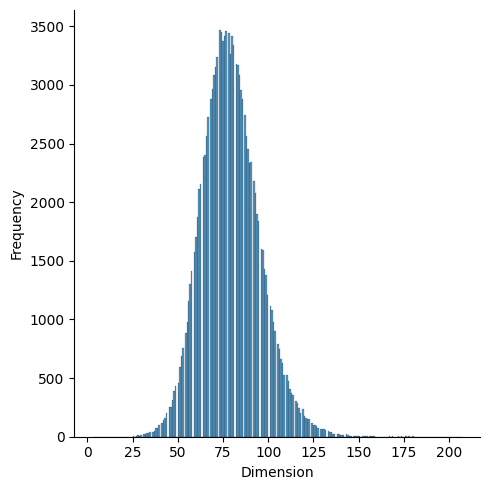

In [58]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will enforce a minimum image size.

In [59]:
MIN_IMAGE_SIZE = 20
IMAGE_SIZE = 48

def resizeImages():
    # Iterate through all the images and resize to a fixed size
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                current_size = img.size[0]
                if current_size < MIN_IMAGE_SIZE:
                    os.remove(file_path)
                    continue
                
                if current_size != IMAGE_SIZE:
                    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
                
                img = ImageOps.invert(img)
                img.save(file_path)
                
resizeImages()

Now lets check how many images we have in each class and see how balanced the classes are.

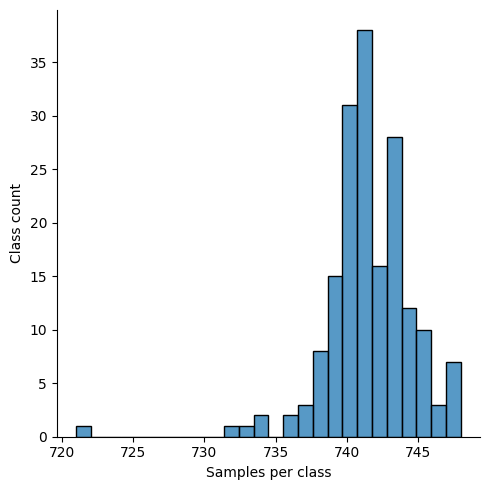

            Count
count  178.000000
mean   741.269663
std      3.031898
min    721.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


In [60]:
def get_class_counts():
    class_counts = {}
    
    for subdir in glob.glob(os.path.join(DIR, '*')):
        file_count = len(glob.glob(os.path.join(subdir, '*')))
        class_counts[subdir.split('/')[-1]] = file_count

    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

df_class_counts = get_class_counts() 

sns.displot(list(df_class_counts['Count']))
plt.xlabel('Samples per class')
plt.ylabel('Class count')
plt.tight_layout()
plt.show()

print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [61]:
df_class_counts = get_class_counts() 

mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

   Count
月    748
零    732
四    734
样    721
老    734
六    733


As we can see, the imbalance is minimal. Because of this, we will not be using any class balancing techniques.

Let's have a look some examples of the images in the dataset.

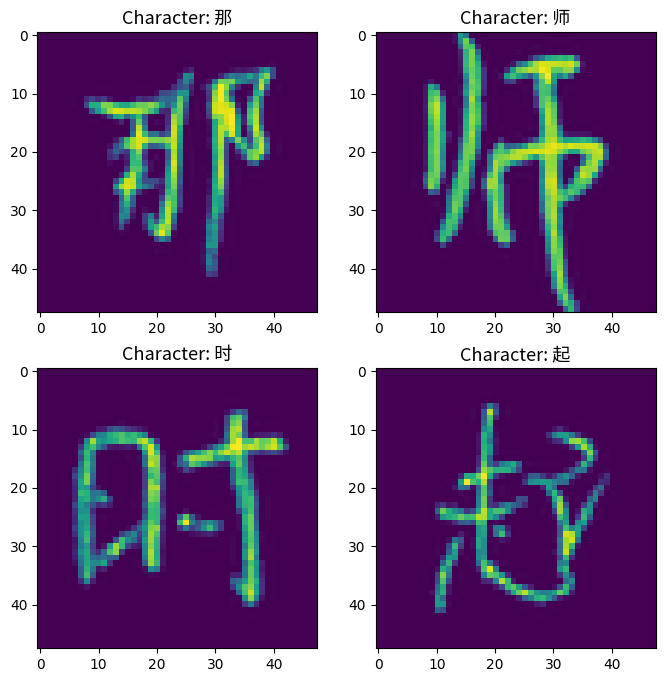

In [62]:
import glob

# Get list of all .png images in the directory and its subdirectories
images = glob.glob(os.path.join(DIR, '**', '*.png'), recursive=True)

# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for i in range(2):
    for j in range(2):
        img_path = random_images[2 * i + j]
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"Character: {img_path.split('/')[1]}", fontproperties=prop,fontsize = 13)

# NumPy Array Conversion

Now we can convert all the images into one single numpy array with the corresponding labels for each image.

In [63]:
def get_numpy_data(classes):
    images = []
    labels = []
    for image_class in classes:
        path = os.path.join(DIR, image_class)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)

            img = Image.open(image_path)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(image_class)
            
    return np.array(images), np.array(labels)

Now we can convert the python lists into numpy arrays.

In [64]:
# random_image_classes = random.sample(image_classes, 50)

images, labels = get_numpy_data(image_classes)

And finally we can save the numpy arrays to the root directory.

In [65]:
np.save('images.npy', images)
np.save('labels.npy', labels)

## CNN Training

In [66]:
images = np.load('images.npy').astype("float32") / 255
labels = np.load('labels.npy')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

def one_hot_encode_labels(y1, y2):
    print(y1)
    print(y2)
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate((y1, y2)))
    
    y1_encoded = label_encoder.transform(y1)
    y2_encoded = label_encoder.transform(y2)
    
    num_classes = len(label_encoder.classes_)
    y1_categorical = to_categorical(y1_encoded, num_classes=num_classes)
    y2_categorical = to_categorical(y2_encoded, num_classes=num_classes)
    
    return y1_categorical, y2_categorical

y_train_ohe, y_test_ohe = one_hot_encode_labels(y_train, y_test)

NUM_CLASSES = y_train_ohe.shape[1]

['儿' '椅' '亮' ... '视' '习' '上']
['喜' '视' '漂' ... '几' '听' '下']


In [67]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)
print(y_train.shape)
print(y_test.shape)

(105556, 48, 48)
(26390, 48, 48)
(105556, 178)
(26390, 178)
(105556,)
(26390,)


In [77]:
def getCNNModel(hp):
    model = Sequential([
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
        
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)),
        
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.7, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [78]:
# from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=15,
    directory='hyperband',
    project_name='cnn_tuning20')

EPOCHS = 30

# annealer = LearningRateScheduler(
#     lambda x: 1e-3 * 0.99 ** (2 * x))
stop_early = EarlyStopping(
    monitor='loss',
    patience=5)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True)

tuner.search(
    X_train, y_train_ohe,
    validation_split=0.2,
    callbacks=[stop_early, checkpoint],
    epochs=EPOCHS, batch_size=128)

Trial 30 Complete [00h 05m 46s]
val_accuracy: 0.9159719347953796

Best val_accuracy So Far: 0.9340185523033142
Total elapsed time: 01h 16m 24s


In [79]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 16, 'dropout_1': 0.1, 'conv_2_filters': 32, 'dropout_2': 0.0, 'dropout_3': 0.2, 'dense_units': 640, 'dropout_4': 0.30000000000000004, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021'}


In [47]:
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_history = []

for i, (train_idxs, val_idxs) in enumerate(kfold.split(X_train, y_train_ohe)):
    print(f"Fold {i + 1}/{k}")
    
    model = load_model('best_model.h5')
    
    history = model.fit(
        X_train[train_idxs],
        y_train_ohe[train_idxs],
        validation_data=(X_train[val_idxs], y_train_ohe[val_idxs]),
        epochs=15,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)

Fold 1/10
Epoch 1/15
1485/1485 [==============================] - 26s 17ms/step - loss: 0.5458 - accuracy: 0.8432 - val_loss: 0.2927 - val_accuracy: 0.9240
Epoch 2/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.5004 - accuracy: 0.8564 - val_loss: 0.2826 - val_accuracy: 0.9252
Epoch 3/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.4608 - accuracy: 0.8677 - val_loss: 0.2671 - val_accuracy: 0.9294
Epoch 4/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.4335 - accuracy: 0.8739 - val_loss: 0.2639 - val_accuracy: 0.9271
Epoch 5/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.4127 - accuracy: 0.8801 - val_loss: 0.2562 - val_accuracy: 0.9292
Epoch 6/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.3870 - accuracy: 0.8864 - val_loss: 0.2473 - val_accuracy: 0.9328
Epoch 7/15
1485/1485 [==============================] - 25s 17ms/step - loss: 0.3706 - accuracy: 0.8910 - val_loss

In [80]:
full_model = load_model('best_model.h5')
feature_model = Model(inputs=full_model.input, outputs=full_model.layers[-4].output)

train_features = feature_model.predict(X_train)
test_features = feature_model.predict(X_test)

825/825 [==============================] - 2s 3ms/step


In [81]:
print(train_features.shape)

(105556, 512)


In [96]:
logistic_regressor = LogisticRegression(
    solver='lbfgs',
    C=10,
    class_weight='balanced',
    max_iter=1000,
    verbose=1,
    n_jobs=-1,
    random_state=42)
logistic_regressor.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        91314     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46968D+05    |proj g|=  2.36777D+02


 This problem is unconstrained.


Epoch 16, change: 0.00339055

At iterate   50    f=  1.74342D+04    |proj g|=  2.84179D+01
Epoch 17, change: 0.00288231
Epoch 18, change: 0.00235588

At iterate  100    f=  1.57870D+04    |proj g|=  6.79064D+00
Epoch 19, change: 0.00191401

At iterate  150    f=  1.56817D+04    |proj g|=  1.17822D+00
Epoch 20, change: 0.00169620

At iterate  200    f=  1.56756D+04    |proj g|=  7.40855D-01
Epoch 21, change: 0.00142414
Epoch 22, change: 0.00113096

At iterate  250    f=  1.56752D+04    |proj g|=  1.02447D-01
Epoch 23, change: 0.00102098

At iterate  300    f=  1.56751D+04    |proj g|=  1.76643D-02
Epoch 24, change: 0.00092178

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N 

LogisticRegression(C=10, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42, verbose=1)

In [97]:
log_predictions = logistic_regressor.predict(test_features)

In [98]:
report = classification_report(y_test, log_predictions, digits=4)
print(report)

              precision    recall  f1-score   support

           一     0.9673    0.9933    0.9801       149
           七     0.9139    0.9324    0.9231       148
           三     0.9660    0.9595    0.9627       148
           上     0.9726    0.9595    0.9660       148
           下     0.9231    0.9664    0.9443       149
           不     0.9524    0.9396    0.9459       149
           东     0.8921    0.8322    0.8611       149
           个     0.9660    0.9530    0.9595       149
           中     0.8882    0.9122    0.9000       148
           么     0.9286    0.9728    0.9502       147
           九     0.9200    0.9262    0.9231       149
           习     0.9342    0.9530    0.9435       149
           书     0.9342    0.9595    0.9467       148
           买     0.9116    0.9054    0.9085       148
           了     0.9119    0.9797    0.9446       148
           二     0.9423    0.9866    0.9639       149
           五     0.9489    0.8784    0.9123       148
           些     0.9600    

Epoch 25, change: 0.00082059
Epoch 26, change: 0.00079580
Epoch 27, change: 0.00069928
Epoch 28, change: 0.00062488
Epoch 29, change: 0.00057560
Epoch 30, change: 0.00052310
Epoch 31, change: 0.00046391
Epoch 32, change: 0.00038868
Epoch 33, change: 0.00042841
Epoch 34, change: 0.00031747
Epoch 35, change: 0.00039718
Epoch 36, change: 0.00026128
Epoch 37, change: 0.00024218
Epoch 38, change: 0.00027712
Epoch 39, change: 0.00022358


In [86]:
param_grid = {
    'n_neighbors': [12, 13, 14, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
grid_search.fit(train_features, y_train_ohe)

knn = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

print("Best score:", grid_search.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
Best score: 0.7445337072264959


In [88]:
f1s = []
accuracys = []

for i in range(2, 50, 1):
    # Create an instance of the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean", weights='distance', n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(train_features, y_train)
    
    # Predict the labels for the test data
    knn_predictions = knn.predict(test_features)
    
    # Calculate the accuracy score
    accuracys.append(accuracy_score(y_test, knn_predictions))

    # Calculate the f1 score
    f1s.append(f1_score(y_test, knn_predictions, average='weighted'))
    
    print(f"k={i}, {accuracys[-1]}, {f1s[-1]}")

k=2, 0.8381205001894657, 0.8387240538967996
k=3, 0.8566123531640774, 0.8571649917387293
k=4, 0.8629784009094353, 0.8637039430644583
k=5, 0.8650625236832133, 0.8660843958678067
k=6, 0.8676392572944297, 0.868776534310295
k=7, 0.8676013641530883, 0.8688886930342263
k=8, 0.8683592269799166, 0.8697706986868178
k=9, 0.8678287230011368, 0.8692751101932903
k=10, 0.8674118984463812, 0.8691277203368415
k=11, 0.8670329670329671, 0.8688663766995725
k=12, 0.8676392572944297, 0.8696946890274262
k=13, 0.8661614247821144, 0.8682940756903367
k=14, 0.8669571807502842, 0.8692623831649409
k=15, 0.8663129973474801, 0.8687254537606021
k=16, 0.8654414550966275, 0.8679883199311986
k=17, 0.864304660856385, 0.8669645335413411
k=18, 0.8627889352027283, 0.8654820769398032
k=19, 0.8634710117468738, 0.8662422366975451
k=20, 0.8627131489200455, 0.8655019913357126
k=21, 0.861576354679803, 0.8644720318361776
k=22, 0.8608942781356574, 0.8637980957092172
k=23, 0.859681697612732, 0.8626917605422004
k=24, 0.85903751420992

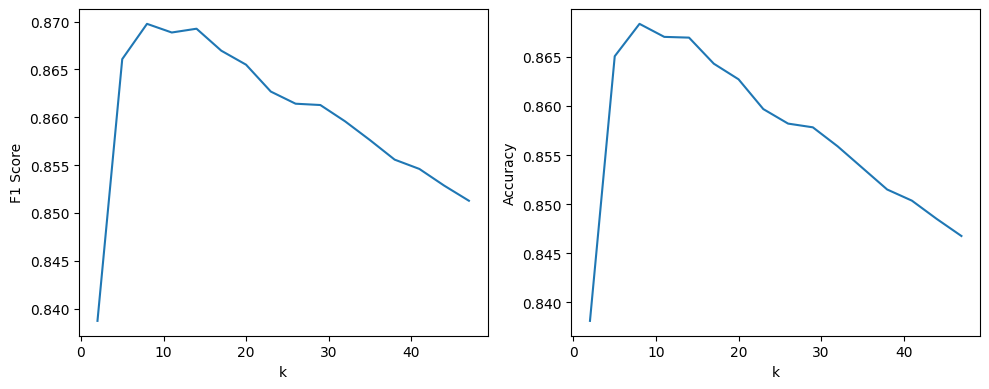

Epoch 64, change: 0.00024360
Epoch 65, change: 0.00025953
Epoch 66, change: 0.00027764
Epoch 67, change: 0.00019721
Epoch 68, change: 0.00023430
Epoch 69, change: 0.00021120
Epoch 70, change: 0.00022481
Epoch 71, change: 0.00023970
Epoch 72, change: 0.00022080
Epoch 73, change: 0.00036248
Epoch 74, change: 0.00020446
Epoch 75, change: 0.00021769
Epoch 76, change: 0.00022600
Epoch 77, change: 0.00021044
Epoch 78, change: 0.00039564
Epoch 79, change: 0.00020218
Epoch 80, change: 0.00022560
Epoch 81, change: 0.00020658
Epoch 82, change: 0.00020849
Epoch 83, change: 0.00028184
Epoch 84, change: 0.00021702
Epoch 85, change: 0.00040486
Epoch 86, change: 0.00037277
Epoch 87, change: 0.00021757
Epoch 88, change: 0.00018557
Epoch 89, change: 0.00034494
Epoch 90, change: 0.00020341
Epoch 91, change: 0.00022183
Epoch 92, change: 0.00020445
Epoch 93, change: 0.00022097


In [102]:
STEP = 3
k_values = range(2, 50, STEP)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(k_values, f1s[::STEP])
ax1.set_xlabel('k')
ax1.set_ylabel('F1 Score')

ax2.plot(k_values, accuracys[::STEP])
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.8s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [15]:
rf_score = rf.score(test_features, y_test)
print(f"Random Forest Accuracy: {rf_score}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


Random Forest Accuracy: 0.8707086017430845


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=2, verbose=1)

# Fit the classifier to the training data using grid search
grid_search.fit(train_features, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [9]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9421918223502217


In [56]:
from sklearn.svm import SVC
svm_classifier = SVC(C=10, gamma='scale', kernel='rbf')
svm_classifier.fit(train_features, y_train)
# Predict the labels for the test data using the best estimator
svm_predictions = svm_classifier.predict(test_features)

In [ ]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, svm_predictions)

# Calculate the f1 score
f1 = f1_score(y_test, svm_predictions, average='weighted')

# Print the accuracy and f1 score report
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.951951496779083
F1 Score: 0.9520046665214275
